In [2]:
import numpy as np
import scipy.linalg as la
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from plot_utils import *

nburnin = 500
nsample = 1000
niter = nburnin + nsample

# 1. Univariate normal

Model specification:

$$\mu\sim N(0,1)$$

$$X|\mu\sim N(\mu, 1)$$

We simulate data $X$ from $N(1, 1)$ and compare the posterior samples from HMC and the theoretical posterior distribution.

In [16]:
np.random.seed(2019)
sample_mean = 1
sample_sig2 = 1
X = np.random.normal(sample_mean, sample_sig2, size = 10000)

U = lambda mu: mu**2/2 + np.sum((X-mu)**2/2)
gradU = lambda mu: mu + np.sum(mu-X)

# theoretical distribution
sig2_pos = 1/(1/1 + len(X) / np.cov(X))
mean_pos = (0 + X.mean()*len(X)/np.cov(X))/(1/1 + len(X) / np.cov(X))
dist = multivariate_normal(mean_pos, (sig2_pos))
sim = np.random.normal(mean_pos, np.sqrt(sig2_pos), nsample)

In [17]:
def leapfrog(gradU, p, r, eps = 0.01, L = 100, M_i = np.array([[1,0],[0,1]])):
    """
    Using leapfrog to discretize
    
    Args:
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix (omitted since assumed to be identity)
    """
    
    r = r - eps/2 * gradU(p)
    for i in range(L-1):
        p = p + eps * r
        r = r - eps * gradU(p)
    
    p = p + eps * r
    r = r - eps/2 * gradU(p)
    
    return p, r

In [18]:
def log_r(U, p0, r0, p, r, M_i = np.array([[1,0],[0,1]])):
    """log of acceptance ratio"""
    return (U(p0) + 1/2*r0.dot(r0)) - (U(p0) + 1/2*r.dot(r))

In [50]:
eps = 0.0005
L = 50
# M_i = np.array([[1]]) # for we assume Mass matrix M either to be identity or 1, it can be omitted.

samples = np.zeros(niter+1)
p = np.array([0.0])
samples[0] = p
np.random.seed(2019)
for k in range(niter):
    r0 = np.random.normal(0,1,1)
    p, r = leapfrog(gradU, p, r0, eps, L)

    # M-H
    p0 = samples[k]
    a = np.exp(log_r(U, p0, r0, p, r))
    u = np.random.rand()

    if u < a:
        samples[k+1] = p
    else:
        samples[k+1] = p0
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")

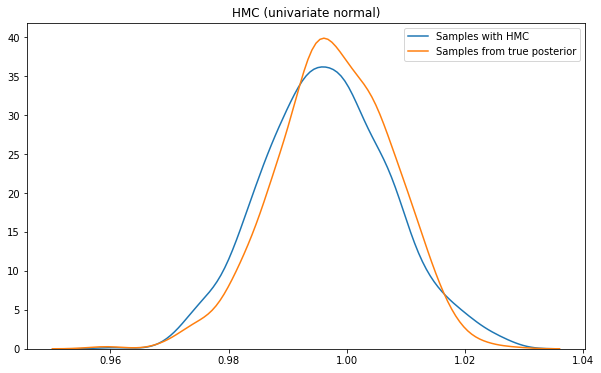

In [52]:
plt.figure(figsize=(10,6))
sns.kdeplot(samples[nburnin+1:], label = 'Samples with HMC')
sns.kdeplot(sim, label = 'Samples from true posterior')
plt.title("HMC (univariate normal)")
plt.savefig('HMC_1d.png');

# 2. Bivariate normal

Model specification:

$$\mu\sim N(\mathbf 0,\mathbf I_{2\times2})$$

$$X|\mu\sim N(\mu, \begin{bmatrix}1&0.75\\0.75&1\end{bmatrix})$$

We simulate data $X$ from $N(\begin{bmatrix}1\\-1\end{bmatrix}, \begin{bmatrix}1&0.75\\0.75&1\end{bmatrix})$ and compare the posterior samples from HMC and the theoretical posterior distribution.

In [131]:
mean_or = np.array([1,-1])
sig_or = np.array([[1,0.75],[0.75,1]])
sig_or_i = la.inv(sig_or)
np.random.seed(2019)
data = multivariate_normal(mean_or, sig_or).rvs(100)


Sig_pos = la.inv(len(data)*la.inv(np.cov(data.T)) + np.eye(2))
mean_pos = (la.inv(len(data)*la.inv(np.cov(data.T)) + np.eye(2)) @
            (len(data)*la.inv(np.cov(data.T))@np.mean(data,0) + np.eye(2)@np.zeros(2)))

sim = multivariate_normal(mean_pos, Sig_pos).rvs(nsample)

In [132]:
U = lambda mu: np.sum(np.diag((data - mu)@sig_or_i@(data - mu).T/2)) + 1/2 * mu.T @ mu
gradU = lambda mu: -sig_or_i.dot((data-mu).T).sum(1) + mu

In [133]:
eps = 0.01
L = 100
np.random.seed(2019)

orbit = np.zeros((niter+1, 2))
p = np.array([0,0.0])
orbit[0] = p
for k in range(niter):
    r0 = np.random.normal(0,1,2)
    p, r = leapfrog(gradU, p, r0, 0.01, L)

    # accept-reject
    p0 = orbit[k]
    a = np.exp(log_r(U, p0, r0, p, r))
    u = np.random.rand()

    if u < a:
        orbit[k+1] = p
    else:
        orbit[k+1] = p0
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")

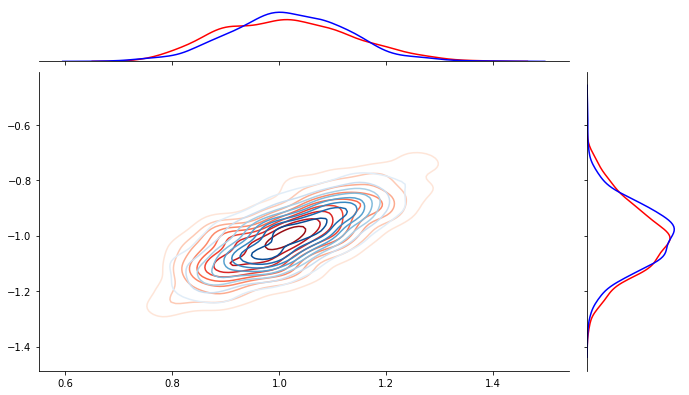

In [136]:
kde_stack(orbit[nburnin+1:,0], orbit[nburnin+1:,1], sim[:,0], sim[:,1])